# Colour Correction using Splines

### Define constants

In [4]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'
CAMERA = 'sigma'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset


### Spectral sensitivities of various cameras

In [6]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)

1939.82119587


### Computing Observer Responses
We can easily change the order of test and train sets here

/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


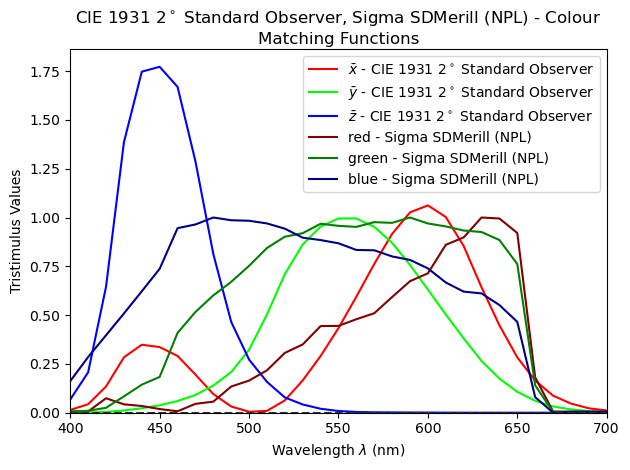

In [7]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Chromaticity Diagrams

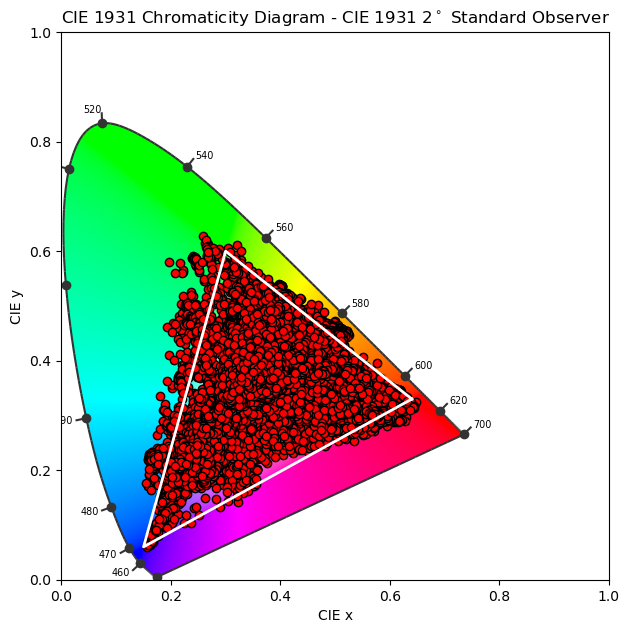

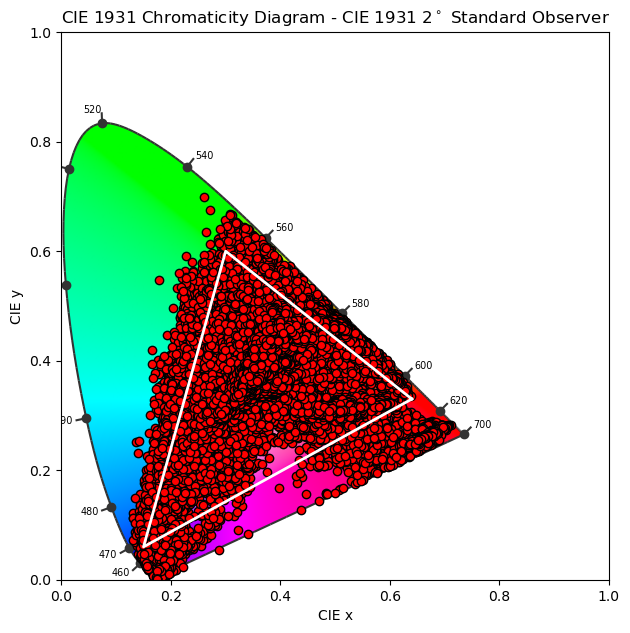

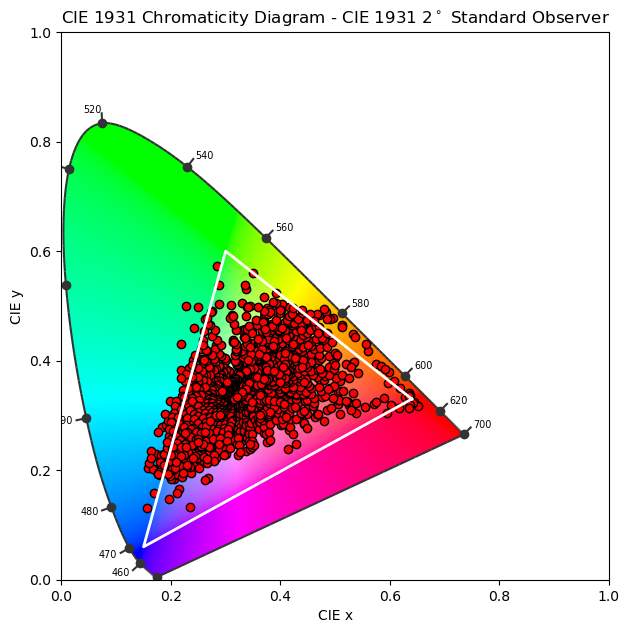

In [8]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Camera Responses

In [9]:
response_trainset_camera, wb1 = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_camera, wb2 = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)
response_validationset_camera,  wb3 = colour.characterisation.training_data_sds_to_RGB(VALIDATION, MSDS_TRAIN, SDS_TRAIN)


print(np.max(response_trainset_camera))
print(np.max(response_testset_camera))
print(np.max(response_validationset_camera))

0.958464477666
0.954189469601
0.870478908159


### Fit Generalized Additive Model with P-splines

### Nikon

In [ ]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
gam = GAMOptimizer(lams=1e-6, order=3, n_splines=5)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
# gam = GAMOptimizer(lams=0.01,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

### Sigma

In [11]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
gam = GAMOptimizer(lams=1e-9, order=3, n_splines=5)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

225
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.73
DeltaE max: 17.78
DeltaE median: 1.41
DeltaE 95 percentile: 4.05
DeltaE 99 percentile: 5.82


In [ ]:
gam.plot_4d()

(100, 100)
6.08575704812
-1.65518615269


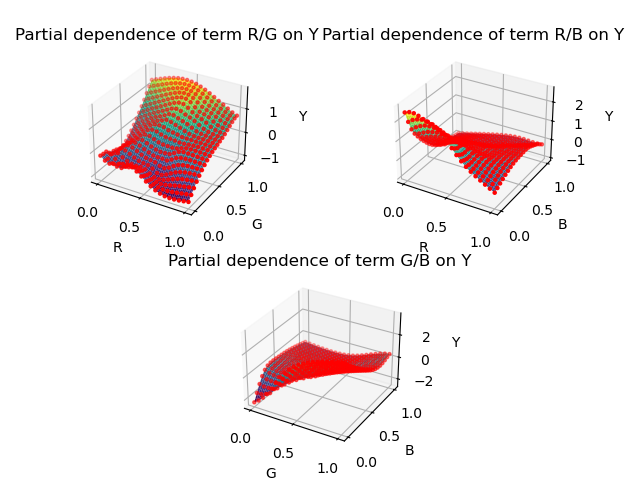

In [ ]:
%matplotlib ipympl

gam.plot_partial_dependences_for_Y()

### Fit Linear Model

In [ ]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)


linear.fit(response_trainset_camera, response_trainset_xyz)
pred(linear, response_testset_camera, response_testset_xyz, "Foster 50")


---- RESULTS Foster 50 ----
DeltaE mean: 2.15
DeltaE max: 23.10
DeltaE median: 1.47
DeltaE 95 percentile: 6.89
DeltaE 99 percentile: 10.55


### Fit 3rd order Root-Polynomial Model

In [ ]:
from models import PolynomialTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])

RP_linear_3.fit(response_trainset_camera, response_trainset_xyz)

pred(RP_linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.28
DeltaE max: 34.54
DeltaE median: 1.62
DeltaE 95 percentile: 6.82
DeltaE 99 percentile: 11.29


### Fit a 2nd order Root-Polynomial Model

In [ ]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_2 = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])


RP_linear_2.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_2, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.13
DeltaE max: 25.34
DeltaE median: 1.47
DeltaE 95 percentile: 6.75
DeltaE 99 percentile: 10.02


In [ ]:
P_Linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_Linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.88
DeltaE max: 20.33
DeltaE median: 1.45
DeltaE 95 percentile: 4.95
DeltaE 99 percentile: 8.11
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.88
DeltaE max: 20.33
DeltaE median: 1.45
DeltaE 95 percentile: 4.95
DeltaE 99 percentile: 8.11


In [ ]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_linear.fit(response_trainset_camera, response_trainset_xyz)
pred(P_linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.97
DeltaE max: 21.66
DeltaE median: 1.45
DeltaE 95 percentile: 5.74
DeltaE 99 percentile: 9.15


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000P = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=3))
])


DE2000P.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000P, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000P, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.518098642321906
        x: [ 8.891e-01 -6.698e-01 ..., -2.069e+01  3.203e+01]
      nit: 632
      jac: [ 7.942e-06  7.421e-06 ...,  2.235e-07 -5.513e-06]
 hess_inv: [[ 2.570e+00 -4.632e+00 ...,  2.766e+01 -3.442e+01]
            [-4.632e+00  1.044e+01 ..., -7.336e+00  6.744e+00]
            ..., 
            [ 2.766e+01 -7.336e+00 ...,  4.019e+04 -2.136e+04]
            [-3.442e+01  6.744e+00 ..., -2.136e+04  9.587e+04]]
     nfev: 38396
     njev: 662
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.95
DeltaE max: 17.12
DeltaE median: 1.71
DeltaE 95 percentile: 4.33
DeltaE 99 percentile: 6.25
---- RESULTS DeltaE SFU ----
DeltaE mean: 2.47
DeltaE max: 16.10
DeltaE median: 2.11
DeltaE 95 percentile: 5.90
DeltaE 99 percentile: 9.15


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=True, degree=3))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.66709200727
        x: [-5.490e+00 -1.349e+02 ..., -3.382e+01 -2.221e+00]
      nit: 279
      jac: [ 9.428e-03  9.195e-03 ...,  1.027e-02  1.016e-02]
 hess_inv: [[ 3.406e+04 -4.631e+04 ..., -1.297e+04 -3.531e+04]
            [-4.631e+04  7.202e+04 ...,  1.904e+04  5.061e+04]
            ..., 
            [-1.297e+04  1.904e+04 ...,  1.315e+04  1.157e+04]
            [-3.531e+04  5.061e+04 ...,  1.157e+04  3.884e+04]]
     nfev: 15059
     njev: 376
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.90
DeltaE max: 35.41
DeltaE median: 1.32
DeltaE 95 percentile: 5.29
DeltaE 99 percentile: 9.12
---- RESULTS DeltaE SFU ----
DeltaE mean: 2.42
DeltaE max: 12.13
DeltaE median: 1.87
DeltaE 95 percentile: 6.32
DeltaE 99 percentile: 7.82


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.606288064622248
        x: [ 8.310e-01 -5.167e-01  6.326e-01 -4.847e-01  1.815e+00
            -3.243e-01  8.772e-01 -4.128e+00  4.235e+00]
      nit: 31
      jac: [ 2.652e-06  2.265e-06  1.848e-06 -1.699e-06 -1.311e-06
            -8.941e-07  7.153e-07  7.153e-07  7.749e-07]
 hess_inv: [[ 1.235e+00 -2.756e+00 ..., -2.350e+00  1.444e+00]
            [-2.756e+00  6.855e+00 ...,  5.973e+00 -3.827e+00]
            ..., 
            [-2.350e+00  5.973e+00 ...,  9.716e+00 -6.439e+00]
            [ 1.444e+00 -3.827e+00 ..., -6.439e+00  4.419e+00]]
     nfev: 400
     njev: 40
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.51
DeltaE max: 18.80
DeltaE median: 2.09
DeltaE 95 percentile: 5.51
DeltaE 99 percentile: 7.86
---- RESULTS DeltaE SFU ----
DeltaE mean: 3.66
DeltaE max: 13.82
DeltaE median: 3.59
DeltaE 95 percentile: 7.14
DeltaE 99 percentile: 9.45


In [ ]:

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
#pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.606288064622248
        x: [ 8.310e-01 -5.167e-01  6.326e-01 -4.847e-01  1.815e+00
            -3.243e-01  8.772e-01 -4.128e+00  4.235e+00]
      nit: 31
      jac: [ 2.652e-06  2.265e-06  1.848e-06 -1.699e-06 -1.311e-06
            -8.941e-07  7.153e-07  7.153e-07  7.749e-07]
 hess_inv: [[ 1.235e+00 -2.756e+00 ..., -2.350e+00  1.444e+00]
            [-2.756e+00  6.855e+00 ...,  5.973e+00 -3.827e+00]
            ..., 
            [-2.350e+00  5.973e+00 ...,  9.716e+00 -6.439e+00]
            [ 1.444e+00 -3.827e+00 ..., -6.439e+00  4.419e+00]]
     nfev: 400
     njev: 40
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.51
DeltaE max: 18.80
DeltaE median: 2.09
DeltaE 95 percentile: 5.51
DeltaE 99 percentile: 7.86


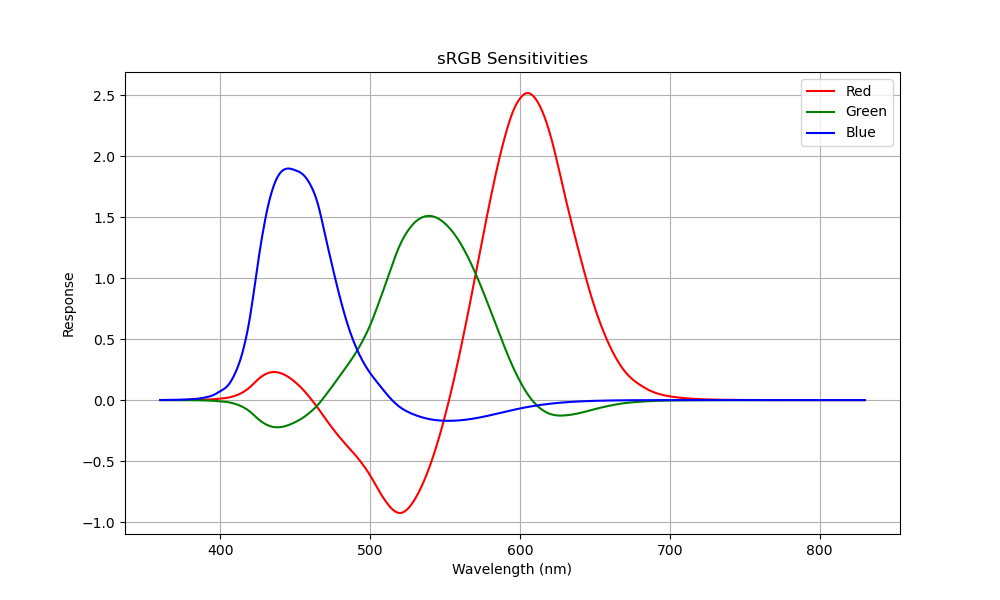

In [ ]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


In [ ]:
from models import GAMOptimizer
from evaluate import pred
from sklearn.pipeline import Pipeline
from models import PolynomialTransformer
from sklearn.linear_model import LinearRegression
from colour import SpectralShape
from colour import MSDS_CAMERA_SENSITIVITIES, MSDS_CMFS
import numpy as np
#spectra = Pipeline([
#    ('transformer', PolynomialTransformer(degree=3, rp=False)),
#    ('regressor', LinearRegression(fit_intercept=False))
# ])

spectra = GAMOptimizer(lams=1e-3, order=3, n_splines=20)


cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy()
MSDS_TRAIN = MSDS_CAMERA_SENSITIVITIES['Nikon 5100 (NPL)']
cmfs.values = cmfs.values / np.max(cmfs.values)
source = MSDS_TRAIN.align(SpectralShape(400, 700, 1)).values
target = cmfs.align(SpectralShape(400, 700, 1)).values
print(MSDS_TRAIN.wavelengths)
spectra.fit(source, target)

[ 400.  401.  402.  403.  404.  405.  406.  407.  408.  409.  410.  411.
  412.  413.  414.  415.  416.  417.  418.  419.  420.  421.  422.  423.
  424.  425.  426.  427.  428.  429.  430.  431.  432.  433.  434.  435.
  436.  437.  438.  439.  440.  441.  442.  443.  444.  445.  446.  447.
  448.  449.  450.  451.  452.  453.  454.  455.  456.  457.  458.  459.
  460.  461.  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.
  472.  473.  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.
  484.  485.  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.
  496.  497.  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.
  508.  509.  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.
  520.  521.  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.
  532.  533.  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.
  544.  545.  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.
  556.  557.  558.  559.  560.  561.  562.  563.  5

GAMOptimizer(lams=0.001, n_splines=20, order=3)

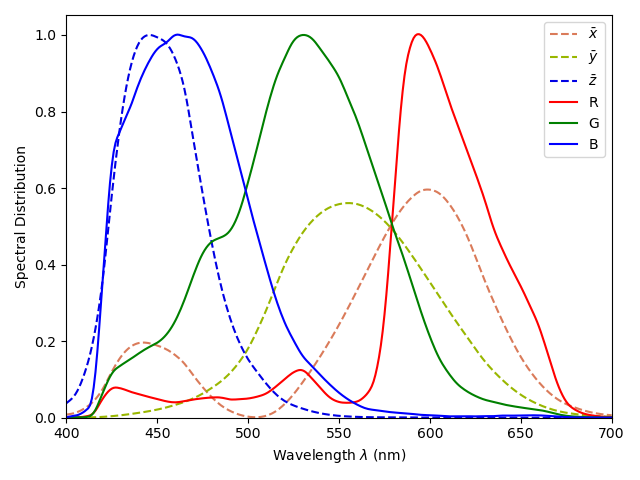

In [ ]:
from colour.plotting import plot_multi_sds
from colour import MultiSpectralDistributions
import matplotlib.pyplot as plt
out = spectra.predict(MSDS_TRAIN.values)
out[out<0] = 0
out_spectra = MultiSpectralDistributions(out, SpectralShape(400, 700, 1))
plot_kwargs = [
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},

    {"use_sd_colours": False, "linestyle": "solid", "color": "red", "label": "R"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "green", "label": "G"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "blue", "label": "B"},
]
fig, ax = plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False)
plt.subplots_adjust(top=0.85)

plt.title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")
plt.savefig("spectralsensitivities.png", transparent=False)

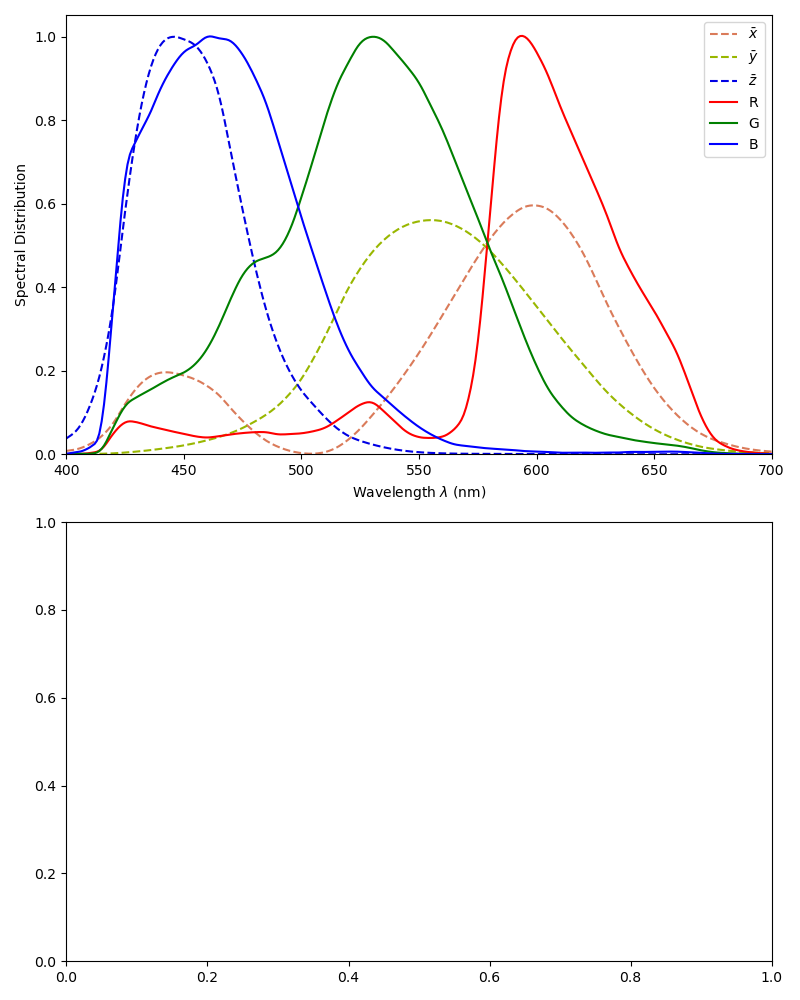

1939.82119587


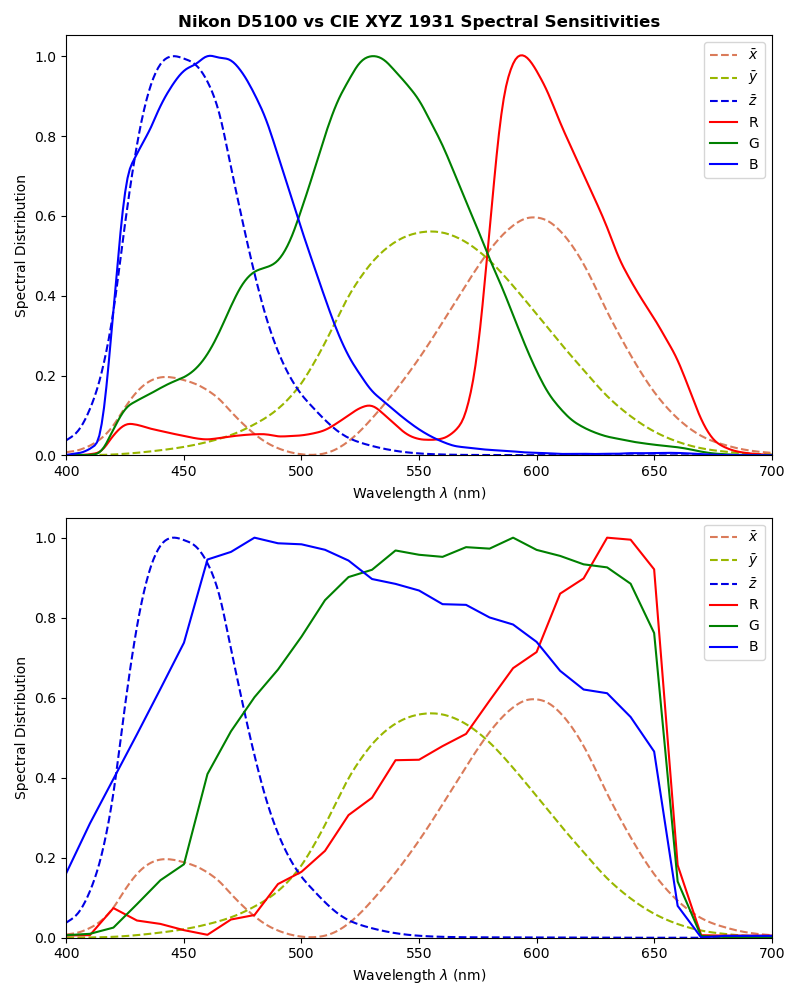

In [ ]:
# Your original plotting code here, modified to include subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Creates 2 rows and 1 column of subplots

# Plot the first set of data on the first subplot
plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[0])
axs[0].set_title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")


MSDS_TEST, SDS_TEST = load_camera('sigma')
# Plot the second set of data on the second subplot
plot_multi_sds([cmfs, MSDS_TEST], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[1])
axs[1].set_title("Sigma SDMerill vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")

# Adjust the layout so that titles and labels don't overlap
plt.tight_layout()

# Save the figure
plt.savefig("spectralsensitivities_subplot.png", transparent=False)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cave_foster2004_dataset.values.T)
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.986817136812
[ 0.82520032  0.12043595  0.0322493   0.00893157]
